<a href="https://colab.research.google.com/github/JingWang98/Text-Mining-and-Sentiment-Analysis-Project/blob/main/I_Hate_You.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I hate you
# Text mining and sentiment analysis
## Author: Jing Wang
## Accademic Year: 2023-2024

In [ ]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.4 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt
import re
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
import os
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, SimpleRNN, Dropout, Dense, BatchNormalization, LSTM
import tensorflow as tf
from keras_tuner import HyperParameters
from sklearn.model_selection import KFold

In [ ]:
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

Define some functions

In [ ]:
# Function for clean_text
def clean_text(text):
    if isinstance(text, str):  # Ensure input is a string
        # Convert to lowercase
        text = text.lower()

        # Remove web links
        text = re.sub(r'https?://\S+|www\.\S+', '', text)

        # Remove special characters
        text = re.sub(r'[^\w\s\']', '', text)

        # Remove numbers
        text = re.sub(r'\d+', '', text)

        return text
    return text

# Function for lemmatization
def lemmatize_text(text):
    # Tokenize text into words
    words = nltk.word_tokenize(text)
    # Lemmatize each word
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    # Join lemmatized words back into a sentence
    return " ".join(lemmatized_words)

# Map nltk POS tags to WordNet POS tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize_with_pos(text):
    words = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(words)  # Get POS tags for words
    lemmatized_words = [
        lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags
    ]
    return " ".join(lemmatized_words)

# functions for the plots loss and accuracy
def performance_plot(history):
    step=int(len(history.history['loss'])/10)

    plt.figure(figsize=(12, 4))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], color = 'red')
    plt.plot(history.history['val_loss'], color = 'orange')
    plt.ylabel('Loss', size=12)
    plt.xlabel('Epoch', size=12)


    plt.xticks(np.arange(0, len(history.history['loss']), step=step), np.arange(1, len(history.history['loss'])+1, step=step))
    plt.yticks(np.arange(0, 1, step=0.1))

    plt.grid(alpha=.25)
    plt.legend(['Train', 'Val'])
    plt.title("Loss over epoch")

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], color = 'red')
    plt.plot(history.history['val_accuracy'],color = 'orange')
    plt.ylabel('Accuracy', size=12)
    plt.xlabel('Epoch', size=12)
    plt.legend(['Train', 'Val'])
    plt.title("Accuracy over epoch")
    plt.grid(alpha=.25)
    plt.xticks(np.arange(0, len(history.history['loss']), step=step), np.arange(1, len(history.history['loss'])+1, step=step))
    plt.yticks(np.arange(0, 1, step=0.1))

    plt.show()


# set seed
def custom_seed_set():
    np.random.seed(42)
    tf.random.set_seed(42)

In [ ]:

!wget https://raw.githubusercontent.com/Vicomtech/hate-speech-dataset/refs/heads/master/annotations_metadata.csv



--2025-01-13 19:52:52--  https://raw.githubusercontent.com/Vicomtech/hate-speech-dataset/refs/heads/master/annotations_metadata.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 348556 (340K) [text/plain]
Saving to: ‘annotations_metadata.csv’

annotations_metadat 100%[===================>] 340.39K  --.-KB/s    in 0.04s   

2025-01-13 19:52:52 (7.77 MB/s) - ‘annotations_metadata.csv’ saved [348556/348556]



In [ ]:
!git clone https://github.com/Vicomtech/hate-speech-dataset

!ls hate-speech-dataset/all_files| wc -l

Cloning into 'hate-speech-dataset'...
remote: Enumerating objects: 10785, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 10785 (delta 6), reused 0 (delta 0), pack-reused 10771 (from 1)
Receiving objects: 100% (10785/10785), 1.16 MiB | 10.83 MiB/s, done.
Resolving deltas: 100% (9/9), done.
10944


In [ ]:
folder_path = "/content/hate-speech-dataset/all_files"

In [ ]:
file_texts = {}

# Iterate through all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".txt"):
        file_path = os.path.join(folder_path, filename)
        with open(file_path, "r") as file:
            content = file.read().strip()
            file_texts[filename] = content

In [ ]:
df = pd.DataFrame(list(file_texts.items()), columns=["Filename", "Text"])
# Remove '.txt' from the column
df['Filename'] = df['Filename'].str.replace('.txt', '', regex=False)

# Display the updated DataFrame
print(df)

         Filename                                               Text
0      31745241_3  Hey , hey army Dirty , Dirty army Hop off your...
1      31330843_2                To be honest , it is long overdue .
2      14298697_3                     The true essence of divinity .
3      30773831_8  American schools have dumbed-down curricula , ...
4      30422349_1          I've seen that game at the store before .
...           ...                                                ...
10939  30701173_1  If it helps you feel better , I got accepted i...
10940  30886654_1  Those you speak of are the very article which ...
10941  13438903_1                            I just took that test .
10942  31527385_2  Have a look on the internet and you can see fo...
10943  14302695_3      They are moving the town of Church 's Falls .

[10944 rows x 2 columns]


In [ ]:
Annotations = pd.read_csv('/content/annotations_metadata.csv')
Annotations

,file_id,user_id,subforum_id,num_contexts,label
0,12834217_1,572066,1346,0,noHate
1,12834217_2,572066,1346,0,noHate
2,12834217_3,572066,1346,0,noHate
3,12834217_4,572066,1346,0,hate
4,12834217_5,572066,1346,0,noHate
...,...,...,...,...,...
10939,33676864_5,734541,1388,0,noHate
10940,33677019_1,735154,1388,0,noHate
10941,33677019_2,735154,1388,0,noHate
10942,33677053_1,572266,1388,0,hate


In [ ]:
# Perform left join with different column names
Final_df = pd.merge(df, Annotations, left_on='Filename', right_on='file_id', how='left')
Final_df

,Filename,Text,file_id,user_id,subforum_id,num_contexts,label
0,31745241_3,"Hey , hey army Dirty , Dirty army Hop off your...",31745241_3,600167,1363,0,noHate
1,31330843_2,"To be honest , it is long overdue .",31330843_2,582650,1346,0,noHate
2,14298697_3,The true essence of divinity .,14298697_3,579878,1380,0,noHate
3,30773831_8,"American schools have dumbed-down curricula , ...",30773831_8,575906,1362,0,noHate
4,30422349_1,I've seen that game at the store before .,30422349_1,574472,1348,0,noHate
...,...,...,...,...,...,...,...
10939,30701173_1,"If it helps you feel better , I got accepted i...",30701173_1,586262,1362,0,noHate
10940,30886654_1,Those you speak of are the very article which ...,30886654_1,572427,1347,0,noHate
10941,13438903_1,I just took that test .,13438903_1,573092,1347,0,noHate
10942,31527385_2,Have a look on the internet and you can see fo...,31527385_2,586780,1363,0,noHate


In [ ]:
# Keep rows with unique values in 'Filename'
Final_df_unique = Final_df.drop_duplicates(subset='Filename', keep=False)
Final_df_unique

,Filename,Text,file_id,user_id,subforum_id,num_contexts,label
0,31745241_3,"Hey , hey army Dirty , Dirty army Hop off your...",31745241_3,600167,1363,0,noHate
1,31330843_2,"To be honest , it is long overdue .",31330843_2,582650,1346,0,noHate
2,14298697_3,The true essence of divinity .,14298697_3,579878,1380,0,noHate
3,30773831_8,"American schools have dumbed-down curricula , ...",30773831_8,575906,1362,0,noHate
4,30422349_1,I've seen that game at the store before .,30422349_1,574472,1348,0,noHate
...,...,...,...,...,...,...,...
10939,30701173_1,"If it helps you feel better , I got accepted i...",30701173_1,586262,1362,0,noHate
10940,30886654_1,Those you speak of are the very article which ...,30886654_1,572427,1347,0,noHate
10941,13438903_1,I just took that test .,13438903_1,573092,1347,0,noHate
10942,31527385_2,Have a look on the internet and you can see fo...,31527385_2,586780,1363,0,noHate


In [ ]:
Data = Final_df_unique[['Text','label']]
Data.head()

,Text,label
0,"Hey , hey army Dirty , Dirty army Hop off your...",noHate
1,"To be honest , it is long overdue .",noHate
2,The true essence of divinity .,noHate
3,"American schools have dumbed-down curricula , ...",noHate
4,I've seen that game at the store before .,noHate


In [ ]:
Data['label'].unique()

array(['noHate', 'hate', 'relation', 'idk/skip'], dtype=object)

In [ ]:
counts = Data['label'].value_counts()
print(counts)

label
noHate      9507
hate        1196
relation     168
idk/skip      73
Name: count, dtype: int64


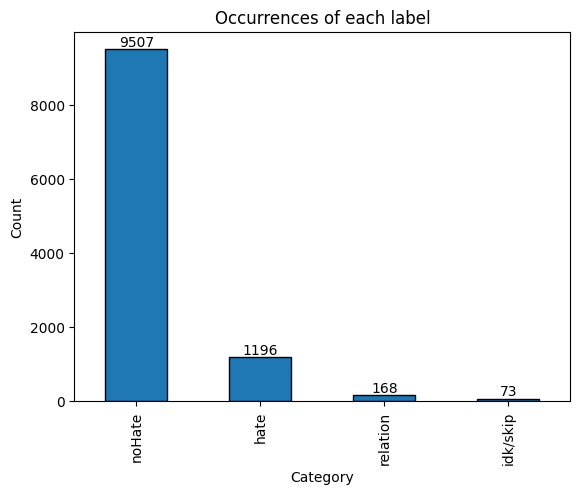

In [ ]:
# Create the bar plot
ax = counts.plot(kind='bar', color='#1f77b4', edgecolor='black')
for i, count in enumerate(counts):
    ax.text(i, count + 0.1, str(count), ha='center', va='bottom', fontsize=10)

plt.title('Occurrences of each label')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

In [ ]:
Data[Data['label'] == 'hate'].iloc[0]['Text']

'I was escorted from the camp/jail by 2 polish policeman as denying/questioning the hoax-acuast is illegal .'

In [ ]:
Data[Data['label'] == 'noHate'].iloc[0]['Text']

'Hey , hey army Dirty , Dirty army Hop off your tanks and follow me We are Marine Corp Infantry Hey , hey navy Nasty , nasty navy Get off your ships and follow me We are Marine Corp Infantry Hey , hey air force Lazy , lazy chair force Get off your chairs and follow me We are Marine Corp Infantry Back in 1775 My Marine Corp came alive First came the color blue To show the world that we are true Then came the color red To show the world the blood we shed Then came the color gold To show the world that we are bold'

In [ ]:
Data[Data['label'] == 'relation'].iloc[0]['Text']

"Its common to for whites to love ethnics when they do n't know any as all they have seen is the pc image of them on tv ."

In [ ]:
Data[Data['label'] == 'idk/skip'].iloc[0]['Text']

'800 Demonstranten gegen NPD-Kundgebung / Aus dem Land / Schleswig-Holstein - KN - Kieler Nachrichten Kiel had an Kurd PKK demostration today .'

In [ ]:
# Count the number of null values in each column
null_counts = Data.isnull().sum()

# Display the count of null values in each column
print(null_counts)

Text     0
label    0
dtype: int64


I decided to keep only "Hate" and "noHate"

In [ ]:
# Drop rows where 'label' is 'relation' or 'idk/skip'
Data = Data[~Data['label'].isin(['relation', 'idk/skip'])]

print("Filtered DataFrame:")
Data.head()

Filtered DataFrame:


,Text,label
0,"Hey , hey army Dirty , Dirty army Hop off your...",noHate
1,"To be honest , it is long overdue .",noHate
2,The true essence of divinity .,noHate
3,"American schools have dumbed-down curricula , ...",noHate
4,I've seen that game at the store before .,noHate


In [ ]:
# Replace values in the 'label' column
Data['label'] = Data['label'].replace({'noHate': 0, 'hate': 1})
Data

<ipython-input-24-2da7c150acb8>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Data['label'] = Data['label'].replace({'noHate': 0, 'hate': 1})


,Text,label
0,"Hey , hey army Dirty , Dirty army Hop off your...",0
1,"To be honest , it is long overdue .",0
2,The true essence of divinity .,0
3,"American schools have dumbed-down curricula , ...",0
4,I've seen that game at the store before .,0
...,...,...
10939,"If it helps you feel better , I got accepted i...",0
10940,Those you speak of are the very article which ...,0
10941,I just took that test .,0
10942,Have a look on the internet and you can see fo...,0


Data preprocessing

1. Lowercasing
2. Removing web links
3. Removing special characters
4. Remove numbers
5. Lemmatization


In [ ]:
Data['Text'] = Data['Text'].apply(clean_text)
Data

,Text,label
0,hey hey army dirty dirty army hop off your t...,0
1,to be honest it is long overdue,0
2,the true essence of divinity,0
3,american schools have dumbeddown curricula co...,0
4,i've seen that game at the store before,0
...,...,...
10939,if it helps you feel better i got accepted in...,0
10940,those you speak of are the very article which ...,0
10941,i just took that test,0
10942,have a look on the internet and you can see fo...,0


In [ ]:
# Initialize the Lemmatizer
lemmatizer = WordNetLemmatizer()

In [ ]:
Data['Text'] = Data['Text'].apply(lemmatize_with_pos)
Data

,Text,label
0,hey hey army dirty dirty army hop off your tan...,0
1,to be honest it be long overdue,0
2,the true essence of divinity,0
3,american school have dumbeddown curricula cour...,0
4,i 've see that game at the store before,0
...,...,...
10939,if it help you feel well i get accept into the...,0
10940,those you speak of be the very article which s...,0
10941,i just take that test,0
10942,have a look on the internet and you can see fo...,0


In [ ]:
# make a copy of dataframe "Data"
Data_new = Data.copy()
Data_new

,Text,label
0,hey hey army dirty dirty army hop off your tan...,0
1,to be honest it be long overdue,0
2,the true essence of divinity,0
3,american school have dumbeddown curricula cour...,0
4,i 've see that game at the store before,0
...,...,...
10939,if it help you feel well i get accept into the...,0
10940,those you speak of be the very article which s...,0
10941,i just take that test,0
10942,have a look on the internet and you can see fo...,0


In [ ]:
# Count the number of words in each row
Data_new['Word_Count'] = Data_new['Text'].str.split().str.len()

print(Data_new)

                                                    Text  label  Word_Count
0      hey hey army dirty dirty army hop off your tan...      0         102
1                        to be honest it be long overdue      0           7
2                           the true essence of divinity      0           5
3      american school have dumbeddown curricula cour...      0          13
4                i 've see that game at the store before      0           9
...                                                  ...    ...         ...
10939  if it help you feel well i get accept into the...      0          25
10940  those you speak of be the very article which s...      0          12
10941                              i just take that test      0           5
10942  have a look on the internet and you can see fo...      0          12
10943            they be move the town of church 's fall      0           9

[10703 rows x 3 columns]


In [ ]:
Data_new['Word_Count'].mean()

16.06138465850696

PMI

In [ ]:
hate_texts = Data_new[Data_new['label'] == 1]['Text']
nohate_texts = Data_new[Data_new['label'] == 0]['Text']


In [ ]:
# Tokenize and count word frequencies
vectorizer = CountVectorizer()
hate_matrix = vectorizer.fit_transform(hate_texts)
nohate_matrix = vectorizer.transform(nohate_texts)

# Get word frequencies for each category
hate_word_counts = hate_matrix.sum(axis=0).A1
nohate_word_counts = nohate_matrix.sum(axis=0).A1
vocab = vectorizer.get_feature_names_out()


In [ ]:
hate_word_counts

array([1, 1, 9, ..., 1, 1, 1])

In [ ]:
# Total word counts
total_hate_words = hate_word_counts.sum()
total_nohate_words = nohate_word_counts.sum()
total_words = total_hate_words + total_nohate_words

# Marginal probabilities
P_hate = total_hate_words / total_words
P_nohate = total_nohate_words / total_words

# Word probabilities
P_w_hate = hate_word_counts / total_words
P_w_nohate = nohate_word_counts / total_words
P_w = (hate_word_counts + nohate_word_counts) / total_words

# PMI calculations
PMI_hate = np.log(P_w_hate / (P_w * P_hate + 1e-10))  # Add small value to avoid division by zero
PMI_nohate = np.log(P_w_nohate / (P_w * P_nohate + 1e-10))


<ipython-input-34-0bb59e0f4ddc>:17: RuntimeWarning: divide by zero encountered in log
  PMI_nohate = np.log(P_w_nohate / (P_w * P_nohate + 1e-10))


In [ ]:
# HATE Score calculation
HS = PMI_hate - PMI_nohate
HS[np.isinf(HS)] = 0

# Create a DataFrame for easy interpretation
hate_score_df = pd.DataFrame({
    'Word': vocab,
    'PMI_HATE': PMI_hate,
    'PMI_NOHATE': PMI_nohate,
    'HATE_Score': HS
})

# Sort by HATE Score
hate_score_df = hate_score_df.sort_values(by='HATE_Score', ascending=True)
print(hate_score_df)


         Word  PMI_HATE  PMI_NOHATE  HATE_Score
3294   thanks -2.681998    0.179159   -2.861157
1559     idea -2.410064    0.175387   -2.585451
986     email -2.221474    0.172087   -2.393560
250      band -2.221474    0.172087   -2.393560
3586    water -2.202425    0.171717   -2.374142
...       ...       ...         ...         ...
1159   filthy  1.594663   -1.754776    3.349440
1758   jungle  1.615278   -1.888308    3.503587
1864  libtard  1.615278   -1.888308    3.503587
1356    groid  1.615283   -1.888307    3.503591
1158    filth  1.623652   -1.948932    3.572584

[3742 rows x 4 columns]


In [ ]:
# Sort the DataFrame by HATE Score in descending order
top_hate_terms = hate_score_df.sort_values(by='HATE_Score', ascending=False).head(10)

# Print the top 10 terms and their scores
print(top_hate_terms[['Word', 'HATE_Score']])

         Word  HATE_Score
1158    filth    3.572584
1356    groid    3.503591
1864  libtard    3.503587
1758   jungle    3.503587
1159   filthy    3.349440
2098  mongrel    3.349435
161       ape    3.321272
2246     nigs    3.167112
2962   sicken    3.167112
1679   invade    3.167112


In [ ]:
# Sort the DataFrame by HATE Score in ascending order
top_noHate_terms = hate_score_df.sort_values(by='HATE_Score', ascending=True).head(10)

# Print the top 10 terms and their scores
print(top_noHate_terms[['Word', 'HATE_Score']])

            Word  HATE_Score
3294      thanks   -2.861157
1559        idea   -2.585451
986        email   -2.393560
250         band   -2.393560
3586       water   -2.374142
3480  university   -2.354340
3441        type   -2.270958
1403       happy   -2.248979
2503          pm   -2.248979
1880        link   -2.215077


<ipython-input-38-2a7a4e0161c5>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Word', y='HATE_Score', data=top_hate_terms, palette='Blues_r')


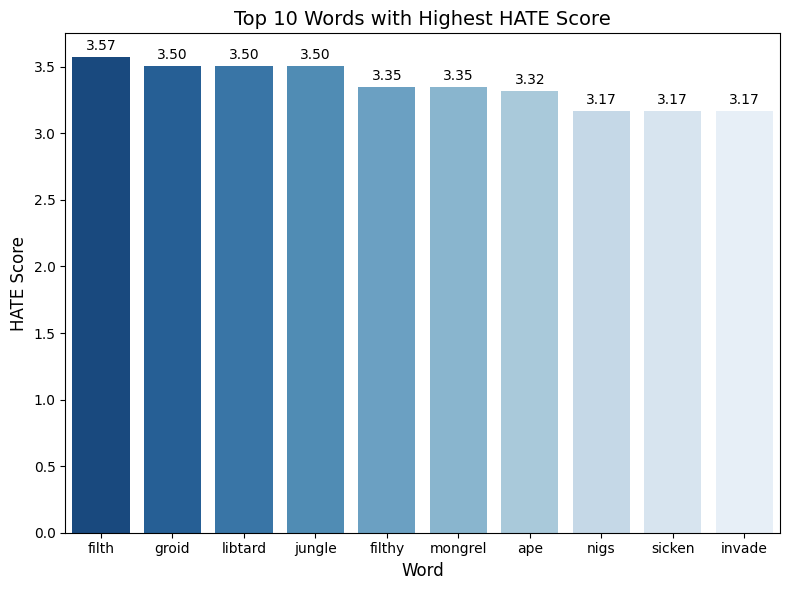

In [ ]:
# Plot a bar chart
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Word', y='HATE_Score', data=top_hate_terms, palette='Blues_r')

for i, count in enumerate(top_hate_terms['HATE_Score']):
    ax.text(i, count + 0.03, f'{count:.2f}', ha='center', va='bottom', fontsize=10)

plt.xlabel('Word', fontsize=12)
plt.ylabel('HATE Score', fontsize=12)
plt.title('Top 10 Words with Highest HATE Score', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
Data_new = Data_new[['label', 'Text']]
Data_new

,label,Text
0,0,hey hey army dirty dirty army hop off your tan...
1,0,to be honest it be long overdue
2,0,the true essence of divinity
3,0,american school have dumbeddown curricula cour...
4,0,i 've see that game at the store before
...,...,...
10939,0,if it help you feel well i get accept into the...
10940,0,those you speak of be the very article which s...
10941,0,i just take that test
10942,0,have a look on the internet and you can see fo...


In [ ]:
# Separate records by label
Hate_df = Data_new[Data_new['label'] == 1]  # All records with label = 1
noHate_df = Data_new[Data_new['label'] == 0]
# Randomly sample 2500 records from noHate_df
nohate_texts_sampled = noHate_df.sample(n=2500, random_state=42)

# Combine the two subsets
balanced_df = pd.concat([Hate_df, nohate_texts_sampled])

# Shuffle the combined dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the resulting balanced DataFrame
print(balanced_df)

      label                                               Text
0         1  that be the sad news i have ever hear in my en...
1         1  the white man have no future in canada that be...
2         1  when i see this stuff nowadays it make me wa n...
3         0  lisa 's grandpa win it in a department poker g...
4         0                  just make for an easy form for me
...     ...                                                ...
3691      1  we should have a new version of the old planta...
3692      0  unfortunatly i be go to miss the of march but ...
3693      1  all of the security guard i see be white but m...
3694      0                                      both be valid
3695      0                               wake up white people

[3696 rows x 2 columns]


In [ ]:
# training and test set
X = balanced_df['Text']
y = balanced_df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("shape of input data: ", X.shape)
print("shape of target variable: ", y.shape)

shape of input data:  (3696,)
shape of target variable:  (3696,)


In [ ]:
X_train

,Text
2887,seem like you cant get away from these parasit...
2715,also people break into a home and shoot and ki...
818,at least shop where a white be at the counter ...
3559,hey and if you ever experience a lawsuit from ...
2578,your medical factor come in to play
...,...
1130,http http http t http make this a great vvalen...
1294,when ever i see these white child murder by th...
860,those visionary and responsible negro
3507,well i have be work on something for self defe...


In [ ]:
print(f"Number of training samples: {X_train.shape[0]}")
print(f"Number of testing samples: {X_test.shape[0]}")

Number of training samples: 2956
Number of testing samples: 740


In [ ]:
tokenizer = Tokenizer(num_words=15000, oov_token='<00V>')
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strings into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20, padding='post') # pads the integer lists to 2D integer tensor

# padding X_test text input data
test_seq = tokenizer.texts_to_sequences(X_test)
test_padseq = pad_sequences(test_seq, maxlen=20, padding='post')

word_index = tokenizer.word_index
max_words = 10000  # total number of words to consider in embedding layer
total_words = len(word_index)
maxlen = 20 # max length of sequence
print("Length of word index:", total_words)


Length of word index: 6194


In [ ]:
print("Sample Sequence:", train_padseq[0])  # Check if the sequences are valid
print("Shape of Sequences:", train_padseq.shape)

Sample Sequence: [ 276   29   15  445   27  300   38   70 1434  775   10 2761    6   27
  152  500    0    0    0    0]
Shape of Sequences: (2956, 20)


In [ ]:
total_words

6194

In [ ]:
print(train_padseq.shape)
print(test_padseq.shape)

(2956, 20)
(740, 20)


In [ ]:
total_words= total_words+1

RNN

In [ ]:
embedding_dim = 100
# Model Structure
model0 = Sequential()

# Embedding Layer: Converts input words to dense vectors of fixed size
model0.add(Embedding(input_dim=total_words, output_dim=embedding_dim, input_length=maxlen))

# Simple RNN Layer:
model0.add(SimpleRNN(64, activation='tanh'))
# Dropout layer for regularization
model0.add(Dropout(0.5))

# Dense Output Layer:
model0.add(Dense(1, activation='sigmoid'))


# Compile the Model
model0.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# fit model to the data
history0 = model0.fit(train_padseq, y_train,
                   batch_size=64,
                    epochs=10,
                    validation_data=(test_padseq, y_test)
                   )

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - accuracy: 0.6542 - loss: 0.6166 - val_accuracy: 0.7446 - val_loss: 0.5294
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8465 - loss: 0.3928 - val_accuracy: 0.7662 - val_loss: 0.4923
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9481 - loss: 0.1763 - val_accuracy: 0.7581 - val_loss: 0.5650
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9812 - loss: 0.0793 - val_accuracy: 0.7459 - val_loss: 0.7131
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9960 - loss: 0.0269 - val_accuracy: 0.7243 - val_loss: 0.7322
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9970 - loss: 0.0165 - val_accuracy: 0.6946 - val_loss: 0.9311
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9978 - loss: 0.0135 - val_accuracy: 0.7243 - val_loss: 0.8808
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0076 - val_accuracy: 0.7311 - val_los

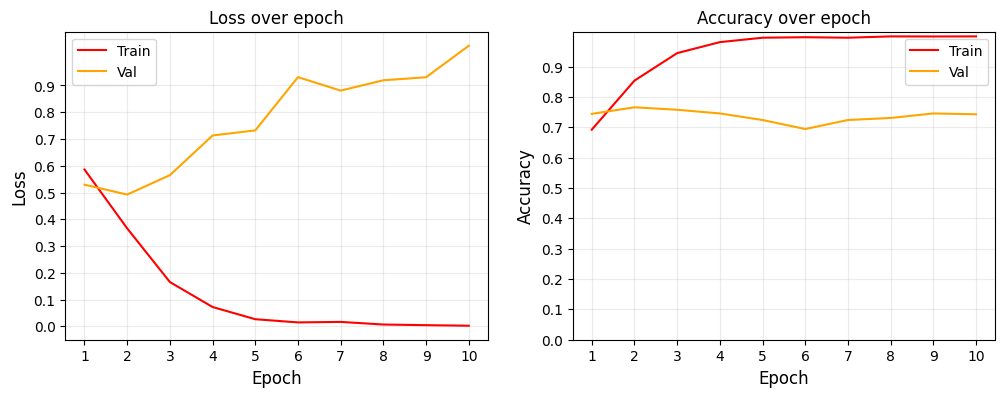

In [ ]:
performance_plot(history0)

In [ ]:
# Build the model
model1 = Sequential()

# Embedding Layer:
model1.add(Embedding(input_dim=total_words, output_dim=embedding_dim, input_length=maxlen))

# Bidirectional SimpleRNN Layer
model1.add(Bidirectional(SimpleRNN(64, dropout=0.3, recurrent_dropout=0.3, activation='relu', return_sequences=True)))

# Another Bidirectional SimpleRNN Layer
model1.add(Bidirectional(SimpleRNN(64, dropout=0.3, recurrent_dropout=0.3, activation='relu', return_sequences=True)))

# SimpleRNN Layer for the output
model1.add(SimpleRNN(32, activation='tanh'))

# Dropout layer for regularization
model1.add(Dropout(0.5))

# Dense layer
model1.add(Dense(1, activation='sigmoid'))

# Compile the model
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# fit model to the data
history1 = model1.fit(train_padseq, y_train,
                   batch_size=64,
                    epochs=15,
                    validation_data=(test_padseq, y_test)
                   )
# SETUP A EARLY STOPPING CALL
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )

Epoch 1/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 201ms/step - accuracy: 0.6263 - loss: 0.6758 - val_accuracy: 0.6608 - val_loss: 0.6090
Epoch 2/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.6743 - loss: 0.6224 - val_accuracy: 0.6595 - val_loss: 0.5987
Epoch 3/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6862 - loss: 0.6113 - val_accuracy: 0.6554 - val_loss: 0.5972
Epoch 4/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7508 - loss: 0.5624 - val_accuracy: 0.6473 - val_loss: 0.6205
Epoch 5/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7876 - loss: 0.4973 - val_accuracy: 0.6486 - val_loss: 0.6438
Epoch 6/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8411 - loss: 0.4067 - val_accuracy: 0.6243 - val_loss: 0.7386
Epoch 7/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8844 - loss: 0.2921 - val_accuracy: 0.6108 - val_loss: 0.8550
Epoch 8/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9242 - loss: 0.1963 - val_accuracy: 0.6311 -

In [ ]:
model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 20, 100)             │         619,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 20, 128)             │          21,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 20, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_3 (SimpleRNN)             │ (None, 32)                  │           5,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,011,529 (7.67 MB)

 Trainable params: 670,509 (2.56 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,341,020 (5.12 MB)

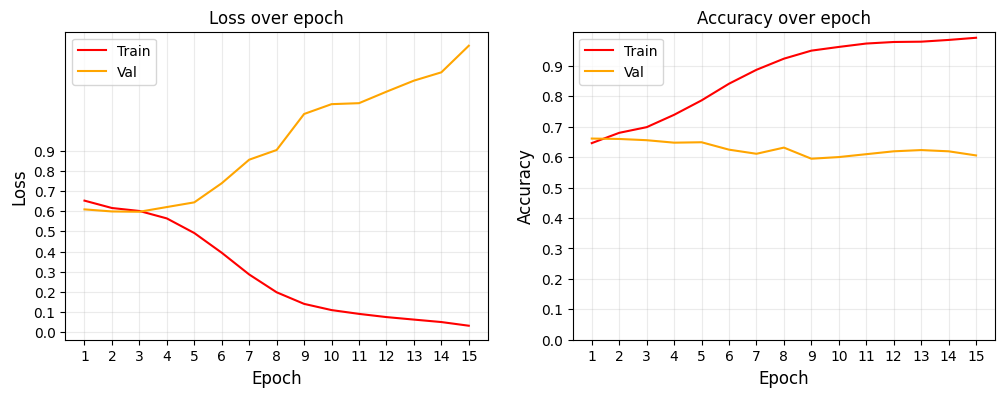

In [ ]:
performance_plot(history1)

In [ ]:
# Build the model
model2 = Sequential()

# Embedding Layer:
model2.add(Embedding(input_dim=total_words, output_dim=embedding_dim, input_length=maxlen))

# Bidirectional SimpleRNN Layer
model2.add(Bidirectional(SimpleRNN(96, dropout=0.3, recurrent_dropout=0.4, activation='relu', return_sequences=True)))

# Another Bidirectional SimpleRNN Layer
model2.add(Bidirectional(SimpleRNN(96, dropout=0.3, recurrent_dropout=0.5, activation='relu', return_sequences=True)))

# SimpleRNN Layer for the output
model2.add(SimpleRNN(64, activation='tanh'))

# Dropout layer for regularization
model2.add(Dropout(0.6))
model2.add(BatchNormalization())

# Dense layer
model2.add(Dense(1, activation='sigmoid',kernel_regularizer=regularizers.l2(0.01)))

# Compile the model
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
# fit model to the data
history2 = model2.fit(train_padseq, y_train,
                   batch_size=64,
                    epochs=30,
                    validation_data=(test_padseq, y_test)
                   )

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


47/47 ━━━━━━━━━━━━━━━━━━━━ 23s 211ms/step - accuracy: 0.5223 - loss: 0.8784 - val_accuracy: 0.6527 - val_loss: 0.6926
Epoch 2/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5478 - loss: 0.8250 - val_accuracy: 0.6608 - val_loss: 0.6409
Epoch 3/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5756 - loss: 0.7680 - val_accuracy: 0.6608 - val_loss: 0.6324
Epoch 4/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6070 - loss: 0.7295 - val_accuracy: 0.6608 - val_loss: 0.6185
Epoch 5/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6254 - loss: 0.7229 - val_accuracy: 0.6608 - val_loss: 0.6179
Epoch 6/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6078 - loss: 0.7329 - val_accuracy: 0.6608 - val_loss: 0.6273
Epoch 7/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6197 - loss: 0.7152 - val_accuracy: 0.6608 - val_loss: 0.6131
Epoch 8/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6259 - loss: 0.6968 - val_accuracy: 0.6608 - val_loss: 

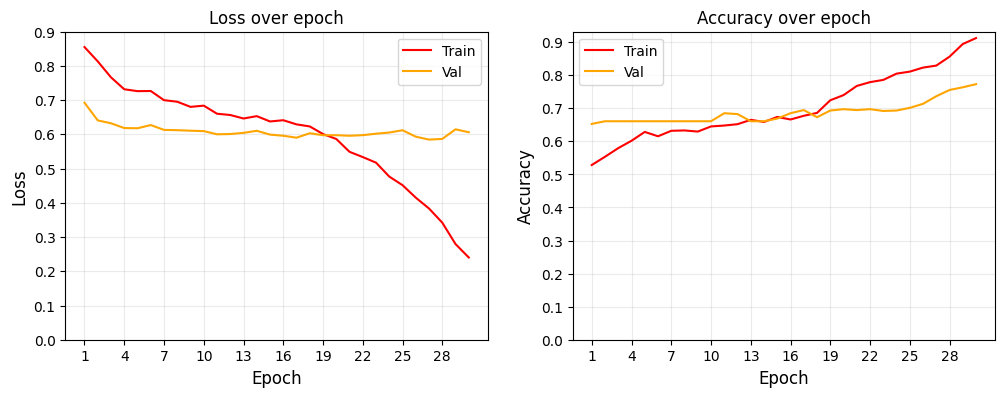

In [ ]:
performance_plot(history2)

Hyperparameter Tuning

In [ ]:
import shutil

# Clear the tuner directory to start fresh
# shutil.rmtree('my_dir', ignore_errors=True)  # Removes the entire directory

In [ ]:
# Define the hypermodel
def build_model(hp):
    model = Sequential()

    # Embedding Layer
    model.add(Embedding(input_dim=total_words,
                        output_dim=hp.Int('embedding_dim', min_value=50, max_value=150, step=50),
                        input_length=maxlen))

    # First Bidirectional RNN layer
    model.add(Bidirectional(SimpleRNN(96,
                                      dropout=hp.Float('dropout_1', min_value=0.3, max_value=0.5, step=0.1),
                                      recurrent_dropout=hp.Float('recurrent_dropout_1', min_value=0.3, max_value=0.5, step=0.1),
                                      activation='relu', return_sequences=True)))

    # Second Bidirectional RNN layer
    model.add(Bidirectional(SimpleRNN(96,
                                      dropout=hp.Float('dropout_2', min_value=0.3, max_value=0.5, step=0.1),
                                      recurrent_dropout=hp.Float('recurrent_dropout_2', min_value=0.3, max_value=0.5, step=0.1),
                                      activation='relu', return_sequences=True)))

    # Final RNN layer (output layer)
    model.add(SimpleRNN(units=hp.Int('units_3', min_value=32, max_value=64, step=32),
                        activation='tanh'))

    # Dropout layer for regularization
    model.add(Dropout(hp.Float('dropout_3', min_value=0.3, max_value=0.6, step=0.1)))
    model.add(BatchNormalization())

    # Output Layer
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.0001, 0.0005, 0.001, 0.0002])),
                  loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Initialize the tuner
tuner = kt.BayesianOptimization(build_model,
                     objective='val_accuracy',  # maximize validation accuracy
                     max_trials=8,
                     executions_per_trial=1,
                     directory='my_dir',  # This will store the tuner results
                     project_name='rnn_tuning')


# Search for the best hyperparameters
tuner.search(train_padseq, y_train, epochs=20, validation_data=(test_padseq, y_test))

# Get the best model
best_model = tuner.get_best_models()[0]
best_model.summary()



Trial 8 Complete [00h 00m 57s]
val_accuracy: 0.7608107924461365

Best val_accuracy So Far: 0.7608107924461365
Total elapsed time: 00h 07m 25s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 20, 150)             │         929,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 20, 192)             │          47,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 20, 192)             │          55,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,048,931 (4.00 MB)

 Trainable params: 1,048,803 (4.00 MB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
tuner.results_summary()

Results summary
Results in my_dir/rnn_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 7 summary
Hyperparameters:
embedding_dim: 150
dropout_1: 0.4
recurrent_dropout_1: 0.5
dropout_2: 0.4
recurrent_dropout_2: 0.4
units_3: 64
dropout_3: 0.5
learning_rate: 0.001
Score: 0.7608107924461365

Trial 2 summary
Hyperparameters:
embedding_dim: 100
dropout_1: 0.3
recurrent_dropout_1: 0.5
dropout_2: 0.5
recurrent_dropout_2: 0.4
units_3: 32
dropout_3: 0.3
learning_rate: 0.0005
Score: 0.6932432651519775

Trial 0 summary
Hyperparameters:
embedding_dim: 150
dropout_1: 0.5
recurrent_dropout_1: 0.4
dropout_2: 0.3
recurrent_dropout_2: 0.5
units_3: 64
dropout_3: 0.3
learning_rate: 0.0005
Score: 0.6891891956329346

Trial 4 summary
Hyperparameters:
embedding_dim: 150
dropout_1: 0.5
recurrent_dropout_1: 0.3
dropout_2: 0.4
recurrent_dropout_2: 0.3
units_3: 32
dropout_3: 0.5
learning_rate: 0.001
Score: 0.683783769607544

Trial 3 summary
Hyperparameters:
embedding_dim: 100
dr

In [ ]:
# Build the model
model_best = Sequential()

# Embedding Layer:
model_best.add(Embedding(input_dim=total_words, output_dim=150, input_length=maxlen))

# Bidirectional SimpleRNN Layer
model_best.add(Bidirectional(SimpleRNN(96, dropout=0.4, recurrent_dropout=0.5, activation='relu', return_sequences=True)))

# Another Bidirectional SimpleRNN Layer
model_best.add(Bidirectional(SimpleRNN(96, dropout=0.4, recurrent_dropout=0.4, activation='relu', return_sequences=True)))

# SimpleRNN Layer for the output
model_best.add(SimpleRNN(64, activation='tanh'))

# Dropout layer for regularization
model_best.add(Dropout(0.5))
model_best.add(BatchNormalization())

# Dense layer
model_best.add(Dense(1, activation='sigmoid',kernel_regularizer=regularizers.l2(0.01)))

# Compile the model
model_best.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
# fit model to the data
history_best = model_best.fit(train_padseq, y_train,
                   batch_size=64,
                    epochs=15,
                    validation_data=(test_padseq, y_test)
                   )
# SETUP A EARLY STOPPING CALL
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


47/47 ━━━━━━━━━━━━━━━━━━━━ 22s 177ms/step - accuracy: 0.5137 - loss: 0.8563 - val_accuracy: 0.6608 - val_loss: 0.6346
Epoch 2/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5850 - loss: 0.7464 - val_accuracy: 0.6608 - val_loss: 0.6400
Epoch 3/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6277 - loss: 0.6984 - val_accuracy: 0.6608 - val_loss: 0.6254
Epoch 4/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6323 - loss: 0.7137 - val_accuracy: 0.6608 - val_loss: 0.6448
Epoch 5/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6420 - loss: 0.6779 - val_accuracy: 0.6608 - val_loss: 0.6395
Epoch 6/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6372 - loss: 0.6681 - val_accuracy: 0.6608 - val_loss: 0.6460
Epoch 7/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6431 - loss: 0.6667 - val_accuracy: 0.6608 - val_loss: 0.6170
Epoch 8/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6537 - loss: 0.6316 - val_accuracy: 0.6608 - val_loss: 

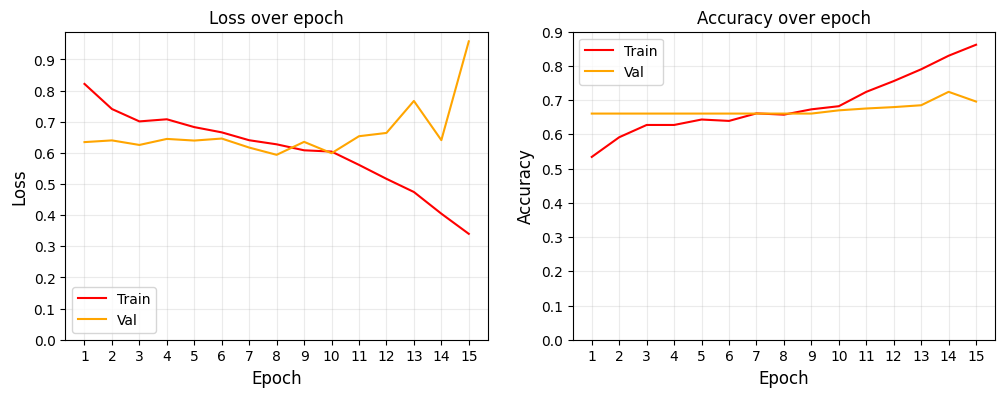

In [ ]:
performance_plot(history_best)

In [ ]:
model_best.evaluate(test_padseq, y_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6783 - loss: 0.9901


[0.9580925107002258, 0.6959459185600281]

In [ ]:
# Build the model
model_lstm = Sequential()

# Embedding Layer:
model_lstm.add(Embedding(input_dim=total_words, output_dim=embedding_dim, input_length=maxlen))

# Add an LSTM layer
model_lstm.add(Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.5, activation='relu',return_sequences=True)))

# Add a second LSTM layer
model_lstm.add(Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.5)))

# Dropout layer for regularization
model_lstm.add(Dropout(0.6))
model_best.add(BatchNormalization())

# Dense layer
model_lstm.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)))

# Compile the model
model_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


# Fit the model to the data
history_lstm = model_lstm.fit(
    train_padseq, y_train,
    batch_size=64,
    epochs=15,
    validation_data=(test_padseq, y_test),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)
    ]
)


Epoch 1/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - accuracy: 0.6427 - loss: 0.6779 - val_accuracy: 0.6608 - val_loss: 0.6110
Epoch 2/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.6778 - loss: 0.5999 - val_accuracy: 0.6608 - val_loss: 0.5882
Epoch 3/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 12s 165ms/step - accuracy: 0.6845 - loss: 0.5811 - val_accuracy: 0.6608 - val_loss: 0.5820
Epoch 4/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.6765 - loss: 0.5975 - val_accuracy: 0.6608 - val_loss: 0.5775
Epoch 5/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.6702 - loss: 0.5887 - val_accuracy: 0.6608 - val_loss: 0.5745
Epoch 6/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 0.6905 - loss: 0.5783 - val_accuracy: 0.6608 - val_loss: 0.5709
Epoch 7/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 0.6761 - loss: 0.5778 - val_accuracy: 0.6608 - val_loss: 0.5627
Epoch 8/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.6801 - loss: 0.5598 - val_accura

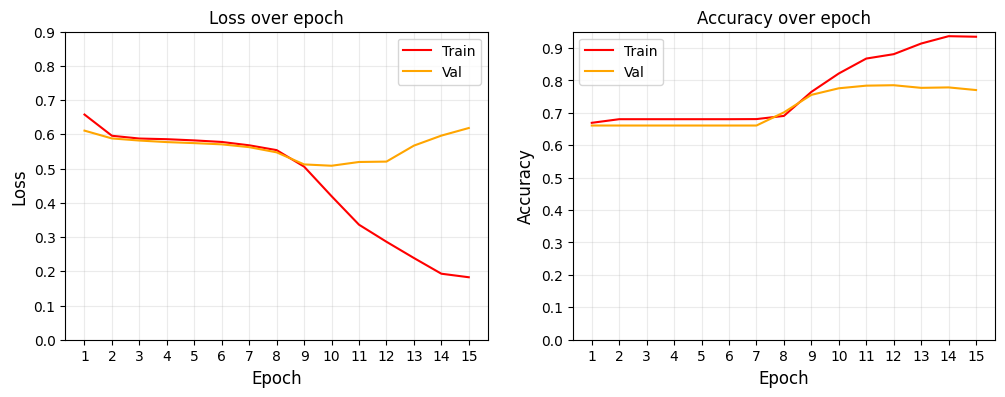

In [ ]:
performance_plot(history_lstm)

In [ ]:
y_pre = model_lstm.predict(test_padseq)
y_pre_label = np.round(y_pre).astype(int).reshape(-1)

incorrect_indexes=np.nonzero(y_pre_label != y_test)[0]

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


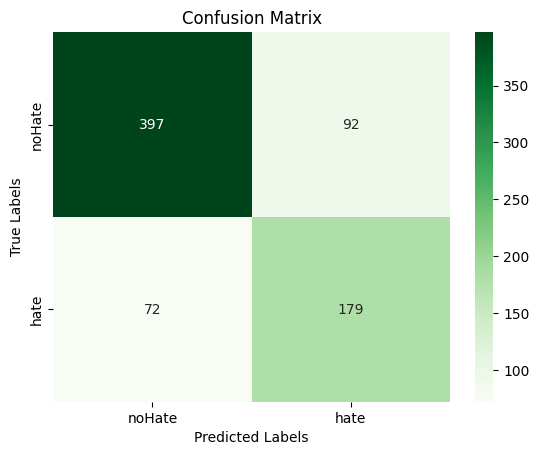

In [ ]:
# Create the confusion matrix
cmf = confusion_matrix(y_test, y_pre_label)

# Display the confusion matrix as a heatmap
sns.heatmap(cmf, annot=True, fmt='d', cmap='Greens', xticklabels=['noHate', 'hate'], yticklabels=['noHate', 'hate'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# For binary classification, use a threshold of 0.5 to classify as 0 or 1
y_pred = (y_pre > 0.5).astype("int32")  # Convert probabilities to binary classes (0 or 1)

# Identify Misclassified Instances
misclassified_mask = (y_pred.flatten() != y_test)

# Filter Misclassified Texts and Their Corresponding Labels
misclassified_text = X_test[misclassified_mask]
misclassified_true_labels = y_test[misclassified_mask]
misclassified_pred_labels = y_pred.flatten()[misclassified_mask]

# Create a DataFrame to Display Misclassified Text with Labels
misclassified_df = pd.DataFrame({
    'Misclassified Text': misclassified_text,
    'True Label': misclassified_true_labels,
    'Predicted Label': misclassified_pred_labels
})

# Display Only the First 5 Misclassified Examples
misclassified_sample = misclassified_df.head(5)

# Print the examples
for _, row in misclassified_sample.iterrows():
    print(f"Misclassified Text: {row['Misclassified Text']}")
    print(f"True Label: {row['True Label']}")
    print(f"Predicted Label: {row['Predicted Label']}")
    print("-" * 80)


Misclassified Text: black and muslim be the majority
True Label: 0
Predicted Label: 1
--------------------------------------------------------------------------------
Misclassified Text: i like to listen to this preacher but why do black prreachers always have to scream
True Label: 1
Predicted Label: 0
--------------------------------------------------------------------------------
Misclassified Text: reality he have no jewish ancestor and he have brown hair and blue eye
True Label: 0
Predicted Label: 1
--------------------------------------------------------------------------------
Misclassified Text: i be go to say before you add that last line they look like a bunch of frightened monkey with gun
True Label: 1
Predicted Label: 0
--------------------------------------------------------------------------------
Misclassified Text: if he 's a coke addict try to find out where he get the coke from and rat him out you will be a hero and can have your own party while all the nigs be behind 